In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
from wordcloud import WordCloud
import matplotlib.dates as mdates
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import langdetect
from langdetect import detect

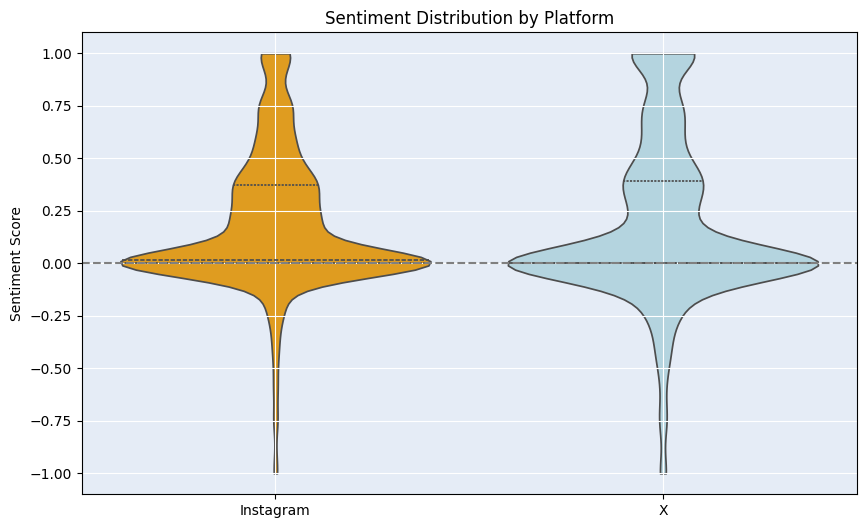

In [2]:
# Load datasets
tweets_before = pd.read_csv("tweets_before.csv")
tweets_after = pd.read_csv("tweets_after.csv")
insta_before = pd.read_csv("final_before.csv")
insta_after = pd.read_csv("final_after.csv")

# Drop duplicate column names
tweets_before = tweets_before.loc[:, ~tweets_before.columns.duplicated()]
tweets_after = tweets_after.loc[:, ~tweets_after.columns.duplicated()]
insta_before = insta_before.loc[:, ~insta_before.columns.duplicated()]
insta_after = insta_after.loc[:, ~insta_after.columns.duplicated()]

# Reset index to ensure uniqueness before merging
tweets_before = tweets_before.reset_index(drop=True)
tweets_after = tweets_after.reset_index(drop=True)
insta_before = insta_before.reset_index(drop=True)
insta_after = insta_after.reset_index(drop=True)

# Add platform column
tweets_before["platform"] = "X"
tweets_after["platform"] = "X"
insta_before["platform"] = "Instagram"
insta_after["platform"] = "Instagram"

# Rename columns to match datasets
insta_before.rename(columns={'timestamp': 'tweetDate', 'caption': 'content'}, inplace=True)
insta_after.rename(columns={'timestamp': 'tweetDate', 'caption': 'content'}, inplace=True)

# Select necessary columns
tweets_before = tweets_before[['tweetDate', 'content', 'platform']]
tweets_after = tweets_after[['tweetDate', 'content', 'platform']]
insta_before = insta_before[['tweetDate', 'content', 'platform']]
insta_after = insta_after[['tweetDate', 'content', 'platform']]

# Merge datasets
df = pd.concat([tweets_before, tweets_after, insta_before, insta_after], ignore_index=True)
df['tweetDate'] = pd.to_datetime(df['tweetDate'], errors='coerce')
df = df.dropna(subset=['content'])

# Function to get sentiment polarity
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Apply sentiment analysis
df['sentiment'] = df['content'].apply(get_sentiment)
df['sentiment'] = df['sentiment'] * 1.5
df['sentiment'] = df['sentiment'].clip(-1, 1)

# Violin Plot
plt.figure(figsize=(10, 6))
plt.gca().set_facecolor("#E5ECF6")
sns.violinplot(x="platform", y="sentiment", hue="platform", data=df, 
               order=["Instagram", "X"], legend=False, 
               palette={"Instagram": "orange", "X": "lightblue"}, 
               inner="quartile", cut=0)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel(None)
plt.ylabel("Sentiment Score")
plt.title("Sentiment Distribution by Platform")
plt.grid(True, color='white', linestyle='-', linewidth=0.8)
plt.show()

Top Topics Identified:
  Topic 1: harris, kamala, president, trump, like, day, america, donald
  Topic 2: victory, trumps, guinea, congratulations, modi, baltasar, engonga, equatorial
  Topic 3: voting, india, says, usa, results, drop, media, read
  Topic 4: support, icon, elon, changed, actively, post, officially, youre
  Topic 5: win, donate, new, kings, stop, political, country, close
  Topic 6: today, wins, actually, kamla, called, night, campaign, repost
  Topic 7: think, american, week, good, winning, presidential, voted, tomorrow
  Topic 8: garbage, women, tweet, days, know, left, time, say
  Topic 9: make, world, people, right, november, man, states, going
  Topic 10: musk, button, united, elections, state, true, fake, thought


<Figure size 1500x800 with 0 Axes>

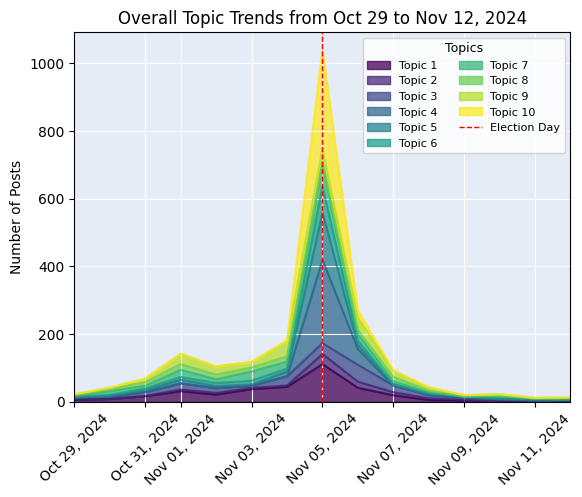

In [3]:
# Initiate NLTK stopwords
nltk_stop_words = set(stopwords.words('english'))

# Load datasets
tweets_before = pd.read_csv("tweets_before.csv")
tweets_after = pd.read_csv("tweets_after.csv")
insta_before = pd.read_csv("final_before.csv")
insta_after = pd.read_csv("final_after.csv")

# Drop duplicate column names
def drop_duplicate_columns(df):
    return df.loc[:, ~df.columns.duplicated()]

tweets_before = drop_duplicate_columns(tweets_before)
tweets_after = drop_duplicate_columns(tweets_after)
insta_before = drop_duplicate_columns(insta_before)
insta_after = drop_duplicate_columns(insta_after)

# Reset index before merging
def reset_index(df):
    return df.reset_index(drop=True)

tweets_before = reset_index(tweets_before)
tweets_after = reset_index(tweets_after)
insta_before = reset_index(insta_before)
insta_after = reset_index(insta_after)

# Add platform column
tweets_before["platform"] = "Twitter"
tweets_after["platform"] = "Twitter"
insta_before["platform"] = "Instagram"
insta_after["platform"] = "Instagram"

# Rename Instagram columns to match Twitter dataset
insta_before.rename(columns={'timestamp': 'tweetDate', 'caption': 'content'}, inplace=True)
insta_after.rename(columns={'timestamp': 'tweetDate', 'caption': 'content'}, inplace=True)

# Select necessary columns
def select_columns(df):
    return df[['tweetDate', 'content', 'platform']]

tweets_before = select_columns(tweets_before)
tweets_after = select_columns(tweets_after)
insta_before = select_columns(insta_before)
insta_after = select_columns(insta_after)

# Merge datasets
df = pd.concat([tweets_before, tweets_after, insta_before, insta_after], ignore_index=True)
df['tweetDate'] = pd.to_datetime(df['tweetDate'], errors='coerce')
df = df.dropna(subset=['content'])

# Filter data for November 1st - November 9th
df = df[(df['tweetDate'] >= '2024-10-29') & (df['tweetDate'] <= '2024-11-13')]

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    text = " ".join([word for word in text.split() if len(word) > 2])  # Remove 2-letter words
    return text

df["clean_content"] = df["content"].apply(clean_text)

# Function to detect language
def is_english(text):
    try:
        return detect(text) == "en"
    except langdetect.lang_detect_exception.LangDetectException:
        return False

# Apply language filtering
df = df[df["clean_content"].apply(is_english)]

# Use NLTK stopwords
def preprocess_text(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in nltk_stop_words]
    return " ".join(tokens)

df["processed_text"] = df["clean_content"].apply(preprocess_text)

# Convert text data using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.6, min_df=10, stop_words="english")
dtm = vectorizer.fit_transform(df["processed_text"])

# Train LDA model
NUM_TOPICS = 10
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(dtm)

# Assign topics to each post
topic_distributions = lda_model.transform(dtm)
df["topic"] = np.argmax(topic_distributions, axis=1)

# Extract feature names correctly
feature_names = np.array(vectorizer.get_feature_names_out())

# Define priority and generic words
priority_political_words = {"trump", "kamala", "election", "vote", "poll", "ballot", "fraud", "democrat", "republican"}
generic_words = {"amp", "dam"}

# Extract topic words with unique assignment
topic_word_scores = lda_model.components_
unique_topic_words = {i: [] for i in range(NUM_TOPICS)}
word_assignments = {}

# Parse top 15 words
for topic_idx, topic in enumerate(topic_word_scores):
    sorted_word_indices = topic.argsort()[-15:][::-1] 
    for word_idx in sorted_word_indices:
        word = feature_names[word_idx]

        # Assign each word to only one topic
        if word not in word_assignments:
            word_assignments[word] = topic_idx
            unique_topic_words[topic_idx].append(word)

# Ensure priority political words are included but not duplicated
for topic_idx in unique_topic_words:
    additional_words = [word for word in priority_political_words if word not in unique_topic_words[topic_idx]]
    
    if len(unique_topic_words[topic_idx]) < 8:
        unique_topic_words[topic_idx].extend(additional_words[:8 - len(unique_topic_words[topic_idx])])

    # Remove generic words and ensure exactly 8 unique words per topic
    unique_topic_words[topic_idx] = [word for word in unique_topic_words[topic_idx] if word not in generic_words]
    unique_topic_words[topic_idx] = list(dict.fromkeys(unique_topic_words[topic_idx]))[:8]

# Print topics with unique words per topic
print("Top Topics Identified:")
for topic_idx, words in unique_topic_words.items():
    print(f"  Topic {topic_idx+1}: {', '.join(words)}")

# Plot improved topic trends
df["date"] = df["tweetDate"].dt.date
topic_counts = df.groupby(["date", "topic"]).size().unstack(fill_value=0)
topic_counts.columns = [f"Topic {i+1}" for i in topic_counts.columns]

# Plot improved topic trends
plt.figure(figsize=(15, 8))
topic_counts.plot(kind="area", stacked=True, colormap="viridis", alpha=0.75)
plt.axvline(pd.Timestamp("2024-11-05"), color="red", linestyle="dashed", linewidth=1, label="Election Day")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.gca().set_facecolor("#E5ECF6")
plt.xlabel(None)
plt.ylabel("Number of Posts")
plt.title("Overall Topic Trends from Oct 29 to Nov 12, 2024")
plt.legend(title="Topics", fontsize=8, title_fontsize=9, loc="upper right", ncol=2, frameon=True)
plt.grid(True, color='white', linestyle='-', linewidth=0.8)
plt.xlim([pd.Timestamp("2024-10-29"), pd.Timestamp("2024-11-12")])
plt.show()